<a href="https://colab.research.google.com/github/brokoli777/Emotion-Recogntion/blob/main/Retry2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import kagglehub

path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:04<00:00, 15.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [4]:
import shutil

# Define source and destination paths
source = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
destination = "/content/dataset"

# Move files to destination folder
shutil.move(source, destination)

print(f"Files moved to {destination}")

Files moved to /content/dataset


In [114]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
TRAIN_DIR = './dataset/test'
TEST_DIR = './dataset/train'

In [7]:
print(os.listdir(TRAIN_DIR))
print(os.listdir(TEST_DIR))

['disgust', 'surprise', 'sad', 'fear', 'angry', 'neutral', 'happy']
['disgust', 'surprise', 'sad', 'fear', 'angry', 'neutral', 'happy']


In [8]:
print(len(os.listdir(TRAIN_DIR+'/angry')))
print(len(os.listdir(TRAIN_DIR+'/disgust')))

958
111


In [9]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)  # Use os.path.join
        if not os.path.isdir(label_path):  # Skip if it's not a directory
            continue

        for filename in os.listdir(label_path):  # Correctly use label_path
            image_path = os.path.join(label_path, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [10]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

disgust Completed
surprise Completed
sad Completed
fear Completed
angry Completed
neutral Completed
happy Completed


,image,label
0,./dataset/test/angry/PrivateTest_29669680.jpg,angry
1,./dataset/test/neutral/PublicTest_3762401.jpg,neutral
2,./dataset/test/happy/PublicTest_87222808.jpg,happy
3,./dataset/test/sad/PublicTest_31246071.jpg,sad
4,./dataset/test/sad/PrivateTest_91999709.jpg,sad


In [11]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

disgust Completed
surprise Completed
sad Completed
fear Completed
angry Completed
neutral Completed
happy Completed


,image,label
0,./dataset/train/disgust/Training_40778169.jpg,disgust
1,./dataset/train/disgust/Training_63957495.jpg,disgust
2,./dataset/train/disgust/Training_94043084.jpg,disgust
3,./dataset/train/disgust/Training_62283849.jpg,disgust
4,./dataset/train/disgust/Training_64347942.jpg,disgust


In [12]:
def get_features(images):
    features = []
    for image in images:
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [13]:
train_features = get_features(train['image'])
test_features = get_features(test['image'])

In [14]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [15]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
encode = LabelEncoder()
encode.fit(train['label'])
y_train = encode.transform(train['label'])
y_test = encode.transform(test['label'])

In [16]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [36]:
input_shape = (48, 48, 1)
output_class = 7

In [112]:
model = Sequential()
model.add(Input(shape=input_shape))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 659,463 (2.52 MB)

 Trainable params: 658,823 (2.51 MB)

 Non-trainable params: 640 (2.50 KB)

In [115]:
early_stopping = EarlyStopping('val_loss', patience=50)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,patience=int(50/4), verbose=1)

model_info = model.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=60,
        verbose=1,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping, reduce_lr]
        )

Epoch 1/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.2130 - loss: 2.1327 - val_accuracy: 0.2513 - val_loss: 1.9533 - learning_rate: 0.0010
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2434 - loss: 1.8603 - val_accuracy: 0.1730 - val_loss: 2.1775 - learning_rate: 0.0010
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2895 - loss: 1.7673 - val_accuracy: 0.1730 - val_loss: 2.8929 - learning_rate: 0.0010
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3215 - loss: 1.6913 - val_accuracy: 0.3047 - val_loss: 2.9415 - learning_rate: 0.0010
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3749 - loss: 1.5779 - val_accuracy: 0.3243 - val_loss: 3.5122 - learning_rate: 0.0010
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3948 - loss: 1.5595 - val_accuracy: 0.2037 - val_loss: 2.9603 - learning_rate: 0.0010
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4310 - loss: 1.4787 - val_a

In [144]:
model.evaluate(x_test, y_test, verbose=1)

898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5170 - loss: 1.6149


[1.396245002746582, 0.5523355007171631]

In [145]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [146]:
# save trained model weight in .h5 file
model.save_weights('model.weights.h5')

In [26]:
model.save("emotionmodel.keras")

In [117]:
accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

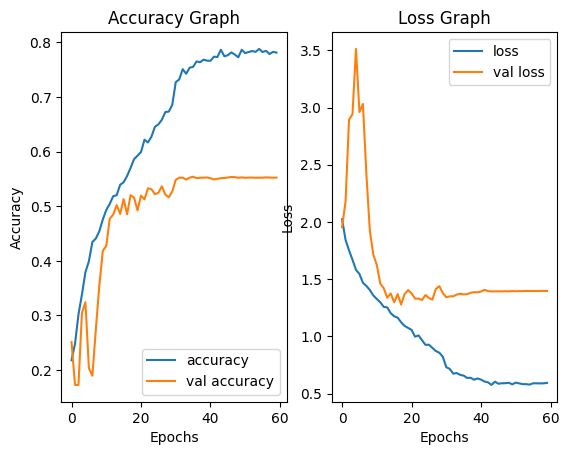

In [118]:
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Original Output: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Output: fear


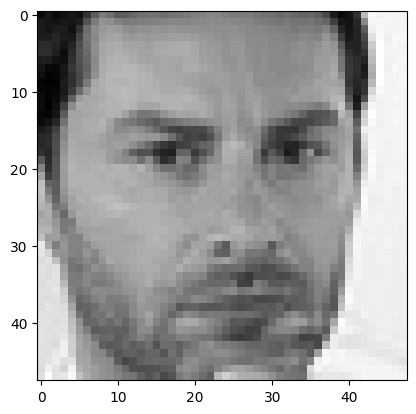

In [142]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = encode.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');